
=== 최종 라벨 테이블 ===
     account_id  ip_flag  residual_flag  large_farming_flag  inactive_flag
0  A_06d5bd3da9    False          False               False          False
1  A_0ad0445c5a    False          False               False           True
2  A_0bfb0b4311    False          False               False          False
3  A_0e72128b0d    False          False               False          False
4  A_1a7c006b71    False          False               False          False

=== Confusion Matrix (inactive) ===
[[38  0]
 [ 0 11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        11

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49


=== Top 20 위험 계정 ===
      account_id  ip_flag  residual_flag  large_farming_flag  inactive_flag  \
41  A_d444580218     True           True       

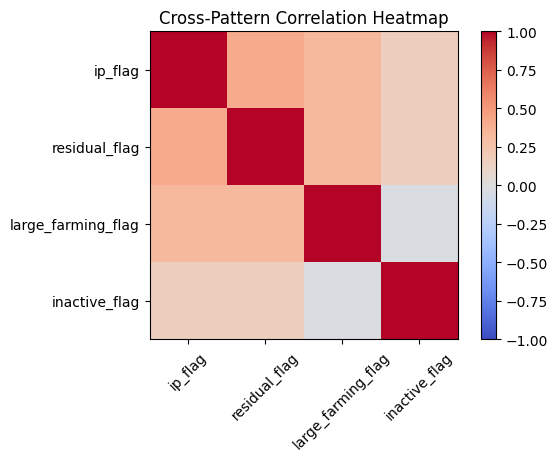


=== Pattern Combination Counts (0000 ~ 1111) ===
pattern_combo
0000    25
0001     8
0010     4
0100     2
0110     2
1000     2
1010     2
1100     1
1101     1
1111     2
Name: count, dtype: int64

=== Top 20 Detail Patterns ===
      account_id  ip_flag  residual_flag  large_farming_flag  inactive_flag  \
41  A_d444580218     True           True                True           True   
48  A_f96ede8d34     True           True                True           True   
9   A_2db64f326b     True           True               False           True   
28  A_7e27164ab6     True           True               False          False   
42  A_dcd87c6c96     True          False                True          False   
44  A_e7205c325a     True          False                True          False   
6   A_26ffea8fd9    False           True                True          False   
39  A_cab220ef3c    False           True                True          False   
14  A_4081f88bb0    False          False               Fa

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

file_path = "problem_data_final.xlsx"

reward = pd.read_excel(file_path, sheet_name="Reward", parse_dates=["ts"])
trade  = pd.read_excel(file_path, sheet_name="Trade", parse_dates=["ts"])
ip     = pd.read_excel(file_path, sheet_name="IP")

# ======================================================
# 1) IP 기반 단기 집중 수령형 라벨
# ======================================================
reward_ip = reward.merge(ip, on="account_id", how="left")
reward_ip = reward_ip.sort_values(["ip", "ts"])

# 10분(=600초) 기준
window_sec = 600

clusters = []
prev = None

for row in reward_ip.itertuples():
    if prev and row.ip == prev.ip and (row.ts - prev.ts).total_seconds() <= window_sec:
        clusters.append((prev.account_id, row.account_id, row.ip, prev.ts, row.ts))
    prev = row

df_cluster = pd.DataFrame(
    clusters,
    columns=["acc1", "acc2", "ip", "ts1", "ts2"]
)

# IP 기반 의심 패턴 발생한 계정 set
ip_suspects = set(df_cluster.acc1).union(set(df_cluster.acc2))

# label_ip 생성 방식 수정
label_ip = pd.DataFrame({"account_id": reward["account_id"].unique()})
label_ip["ip_flag"] = label_ip["account_id"].isin(ip_suspects)


# ======================================================
# 2) 거래 대비 리워드 과다형 (trade_count → reward_count)
# ======================================================
trade_count = trade.groupby("account_id")["ts"].count().reset_index(name="trade_count")
reward_count = reward.groupby("account_id")["ts"].count().reset_index(name="reward_count")

df_lr = trade_count.merge(reward_count, on="account_id", how="inner")

df_lr["log_trade"] = np.log1p(df_lr["trade_count"])
df_lr["log_reward"] = np.log1p(df_lr["reward_count"])

coef = np.polyfit(df_lr["log_trade"], df_lr["log_reward"], 1)
pred = coef[0] * df_lr["log_trade"] + coef[1]

df_lr["residual"] = df_lr["log_reward"] - pred

# 정상 기준 = residual > μ + 0.8σ
thr = df_lr["residual"].mean() + 0.8 * df_lr["residual"].std()

label_residual = df_lr[["account_id"]].copy()
label_residual["residual_flag"] = df_lr["residual"] > thr


# ======================================================
# 3) 대규모 파밍 — 거래량 대비 total_reward 회귀
# ======================================================
trade["amount"] = trade["amount"].astype(float)

total_reward = reward.groupby("account_id")["reward_amount"].sum().reset_index(name="total_reward")
total_notional = trade.groupby("account_id")["amount"].sum().reset_index(name="total_notional")

df_amt = total_reward.merge(total_notional, on="account_id", how="left")

# total_notional이 NaN이면 0으로 처리
df_amt["total_notional"] = df_amt["total_notional"].fillna(0)

df_amt["log_reward"] = np.log1p(df_amt["total_reward"])
df_amt["log_notional"] = np.log1p(df_amt["total_notional"])

# 회귀는 notional > 0인 계정만 대상으로
mask_fit = df_amt["total_notional"] > 0
coef2 = np.polyfit(df_amt.loc[mask_fit, "log_notional"], df_amt.loc[mask_fit, "log_reward"], 1)
pred2 = coef2[0] * df_amt["log_notional"] + coef2[1]

df_amt["residual2"] = df_amt["log_reward"] - pred2

thr2 = df_amt["residual2"].mean() + 0.8 * df_amt["residual2"].std()

label_amt = df_amt[["account_id"]].copy()
label_amt["large_farming_flag"] = df_amt["residual2"] > thr2


# ======================================================
# 4) 비활동형 라벨 — reward 이후 첫 trade gap (merge_asof 제거 버전)
# ======================================================
reward_sorted = reward.sort_values(["account_id", "ts"])
trade_sorted  = trade.sort_values(["account_id", "ts"])

results = []

for acc, rw in reward_sorted.groupby("account_id"):
    tr = trade_sorted[trade_sorted["account_id"] == acc].sort_values("ts")

    # 이 계정에 아예 거래가 없으면 -> gap NaN
    if tr.empty:
        results.append([acc, np.nan])
        continue

    gaps = []

    for t in rw["ts"]:
        future = tr[tr["ts"] > t]
        if future.empty:
            gaps.append(np.nan)
        else:
            gap_h = (future.iloc[0]["ts"] - t).total_seconds() / 3600
            gaps.append(gap_h)

    median_gap = np.nanmedian(gaps)
    results.append([acc, median_gap])

gap_df = pd.DataFrame(results, columns=["account_id", "gap_hours"])

# 기준 = 14일(336시간)
label_gap = gap_df.copy()
label_gap["inactive_flag"] = (
    label_gap["gap_hours"].isna() |
    (label_gap["gap_hours"] > 336)   # 14일
)


# ======================================================
# 5) 전체 라벨 결합
# ======================================================
labels = label_ip.merge(label_residual, on="account_id", how="outer")
labels = labels.merge(label_amt, on="account_id", how="outer")
labels = labels.merge(label_gap[["account_id", "inactive_flag"]], on="account_id", how="outer")

labels = labels.fillna(False)

print("\n=== 최종 라벨 테이블 ===")
print(labels.head())


# ======================================================
# 6) Confusion Matrix (예시: 비활동형)
#    여기서는 baseline이라 y_true == y_pred 구조
# ======================================================
y_true = labels["inactive_flag"].astype(int).values
y_pred = labels["inactive_flag"].astype(int).values

print("\n=== Confusion Matrix (inactive) ===")
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


# ======================================================
# 7) 리스크 점수 계산
# ======================================================
labels["risk_score"] = (
    1.3 * labels["ip_flag"].astype(int) +
    1.2 * labels["residual_flag"].astype(int) +
    1.0 * labels["large_farming_flag"].astype(int) +
    1.5 * labels["inactive_flag"].astype(int)
)

print("\n=== Top 20 위험 계정 ===")
print(labels.sort_values("risk_score", ascending=False).head(20))

# ======================================================
# 8) Cross-pattern 매트릭스 생성
# ======================================================

pattern_cols = ["ip_flag", "residual_flag", "large_farming_flag", "inactive_flag"]

cross_matrix = labels[pattern_cols].astype(int).corr()

print("\n=== Cross-Pattern Correlation Matrix ===")
print(cross_matrix)

plt.figure(figsize=(6,4))
plt.imshow(cross_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Cross-Pattern Correlation Heatmap")
plt.xticks(range(len(pattern_cols)), pattern_cols, rotation=45)
plt.yticks(range(len(pattern_cols)), pattern_cols)
plt.show()

# ======================================================
# 9) 패턴 조합별 계정 분포
# ======================================================
labels["pattern_combo"] = (
    labels["ip_flag"].astype(int).astype(str) +
    labels["residual_flag"].astype(int).astype(str) +
    labels["large_farming_flag"].astype(int).astype(str) +
    labels["inactive_flag"].astype(int).astype(str)
)

combo_counts = labels["pattern_combo"].value_counts().sort_index()

print("\n=== Pattern Combination Counts (0000 ~ 1111) ===")
print(combo_counts)

# ======================================================
# 10) Top 20 위험계정 패턴 분석
# ======================================================
top20 = labels.sort_values("risk_score", ascending=False).head(20)

print("\n=== Top 20 Detail Patterns ===")
print(top20[["account_id", "ip_flag", "residual_flag", "large_farming_flag", "inactive_flag", "risk_score"]])

top20_accounts = top20["account_id"].tolist()

def show_account(account_id):
    print("="*80)
    print(f"🔍 ACCOUNT ANALYSIS (SUMMARY MODE): {account_id}")
    print("="*80)

    # -------------------------------
    # 1) Reward Summary
    # -------------------------------
    rw = reward[reward["account_id"] == account_id].sort_values("ts")

    print("\n📌 [1] Reward Summary")

    if rw.empty:
        print(" - No reward events")
    else:
        first_rw = rw["ts"].min()
        last_rw = rw["ts"].max()
        days = rw["ts"].dt.date.nunique()
        per_day = rw.groupby(rw["ts"].dt.date).size().max()
        rw_interval = (rw["ts"].diff().dt.total_seconds().dropna()).min()

        print(f" - First Reward: {first_rw}")
        print(f" - Last Reward: {last_rw}")
        print(f" - Active Reward Days: {days}")
        print(f" - Max Rewards in a Single Day: {per_day}")
        print(f" - Min Interval Between Rewards: {rw_interval:.1f} sec")


    # -------------------------------
    # 2) Trade Summary
    # -------------------------------
    tr = trade[trade["account_id"] == account_id].sort_values("ts")

    print("\n📌 [2] Trade Summary")

    if tr.empty:
        print(" - No trade events")
    else:
        first_tr = tr["ts"].min()
        last_tr = tr["ts"].max()
        total_notional = tr["amount"].sum()

        long_cnt = len(tr[tr["side"] == "LONG"])
        short_cnt = len(tr[tr["side"] == "SHORT"])

        # reward 이후 첫 trade gap
        gaps = []
        for t in rw["ts"]:
            future = tr[tr["ts"] > t]
            if not future.empty:
                gaps.append((future.iloc[0]["ts"] - t).total_seconds())
        min_gap = min(gaps) if gaps else None

        print(f" - Trade Count: {len(tr)}")
        print(f" - First Trade: {first_tr}")
        print(f" - Last Trade: {last_tr}")
        print(f" - Total Notional: {total_notional:.2f}")
        print(f" - LONG/SHORT: {long_cnt} / {short_cnt}")
        print(f" - Min Reward→Trade Gap: {min_gap} sec")


    # -------------------------------
    # 3) IP Summary
    # -------------------------------
    ip_df = ip[ip["account_id"] == account_id]

    print("\n📌 [3] IP Summary")

    if ip_df.empty:
        print(" - No IP logs")
    else:
        ip_counts = ip_df["ip"].value_counts()
        print(f" - Unique IP Count: {ip_counts.size}")
        print(f" - Top IPs: \n{ip_counts.head(3)}")


    # -------------------------------
    # 4) Ratio Patterns
    # -------------------------------
    reward_cnt = len(rw)
    trade_cnt = len(tr)

    total_reward = rw["reward_amount"].sum()
    total_notional = tr["amount"].sum() if not tr.empty else 0

    print("\n📌 [4] Ratio Pattern")
    print(f" - reward / trade = {reward_cnt} / {trade_cnt} = {reward_cnt / trade_cnt if trade_cnt>0 else np.inf:.2f}")
    print(f" - notional / reward = {total_notional / total_reward if total_reward>0 else np.inf:.2f}")


    # -------------------------------
    # 5) Flags Summary
    # -------------------------------
    row = labels[labels["account_id"] == account_id].iloc[0]
    print("\n📌 [5] Pattern Flags")
    print(row[["ip_flag", "residual_flag", "large_farming_flag", "inactive_flag", "risk_score"]])

    print("="*80)


for acc in top20_accounts:
    show_account(acc)



In [11]:
# ============================================
# Top20 위험계정 표를 줄바꿈 없이 다시 출력
# ============================================

pd.set_option('display.max_columns', None)     # 컬럼 줄바꿈 방지
pd.set_option('display.width', 2000)           # 한 줄 최대 너비 확장
pd.set_option('display.max_colwidth', None)    # 내용 줄바꿈 방지

top20_table = labels.sort_values("risk_score", ascending=False).head(20)[
    ["account_id", "ip_flag", "residual_flag", "large_farming_flag", "inactive_flag", "risk_score"]
]

print("\n=== Top 20 위험 계정 (No line break version) ===")
print(top20_table.to_string(index=False))



=== Top 20 위험 계정 (No line break version) ===
  account_id  ip_flag  residual_flag  large_farming_flag  inactive_flag  risk_score
A_d444580218     True           True                True           True         5.0
A_f96ede8d34     True           True                True           True         5.0
A_2db64f326b     True           True               False           True         4.0
A_7e27164ab6     True           True               False          False         2.5
A_dcd87c6c96     True          False                True          False         2.3
A_e7205c325a     True          False                True          False         2.3
A_26ffea8fd9    False           True                True          False         2.2
A_cab220ef3c    False           True                True          False         2.2
A_4081f88bb0    False          False               False           True         1.5
A_522c68dd44    False          False               False           True         1.5
A_8860be39b3    False         